In [312]:
# script to read in awas data for flights 5 - 14

In [332]:
import xarray as xr
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd

In [333]:
# path to data
mypath = '/mnt/home/sofia/TTS/contrast_merge_data/TOGA/*.nc'

In [334]:
# read in merge all flights 
contrast_init = xr.open_mfdataset(mypath, combine='by_coords')

In [335]:
### --- desired toga tracers
# empyt dataset to fill with toga data (12 total)
toga_trc_prelim = xr.merge([contrast_init.Acetaldehyde, contrast_init.n_Butane, 
                     contrast_init.i_Butane, contrast_init.Benzene, 
                     contrast_init.C3H8, contrast_init.Methanol,
                     contrast_init.Bromoform, contrast_init.Tetrachloroethylene,  
                     contrast_init.Dibromomethane,  contrast_init.Dichloromethane, 
                     contrast_init.Chloroform, contrast_init.Carbon_Tetrachloride])
len(toga_trc_prelim)

12

In [336]:
### --- awas aircraft parameters and location 
toga_param_init = xr.merge([contrast_init.GGALT, contrast_init.GGLAT, contrast_init.GGLON])
                      #contrast_init.WIC, contrast_init.PALT, contrast_init.RHUM])

# find NH values, what we want 
northhem = np.where(toga_param_init.GGLAT.values > 0)
print(np.size(northhem))

# keep only NH values, rewrite to toga_param 
toga_param = xr.Dataset()
for ii in toga_param_init.data_vars:
    param = toga_param_init[ii]
    nh_only = param[northhem].values 
    toga_param[ii] = nh_only
toga_param

2286


/mnt/home/sofia/software/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


<xarray.Dataset>
Dimensions:  (GGALT: 2286, GGLAT: 2286, GGLON: 2286)
Coordinates:
  * GGALT    (GGALT) float32 1447.7172 3127.166 4212.603 ... 4391.697 3358.9587
  * GGLAT    (GGLAT) float32 13.474072 13.379817 ... 12.543944 12.707678
  * GGLON    (GGLON) float32 144.88289 144.9935 145.1362 ... 144.76048 144.72903
Data variables:
    *empty*

In [337]:
# select NH only for all tracers 
toga_trc_nh_noreplace = xr.Dataset()
for ii in toga_trc_prelim.data_vars:
    trc = toga_trc_prelim[ii]
    nh_only = trc[northhem]
    toga_trc_nh_noreplace[ii] = nh_only
toga_trc_nh_noreplace

<xarray.Dataset>
Dimensions:               (Time: 2286)
Coordinates:
  * Time                  (Time) datetime64[ns] 2014-01-17T00:16:06 ... 2014-02-22T09:20:05
Data variables:
    Acetaldehyde          (Time) float32 dask.array<chunksize=(194,), meta=np.ndarray>
    n_Butane              (Time) float32 dask.array<chunksize=(194,), meta=np.ndarray>
    i_Butane              (Time) float32 dask.array<chunksize=(194,), meta=np.ndarray>
    Benzene               (Time) float32 dask.array<chunksize=(194,), meta=np.ndarray>
    C3H8                  (Time) float32 dask.array<chunksize=(194,), meta=np.ndarray>
    Methanol              (Time) float32 dask.array<chunksize=(194,), meta=np.ndarray>
    Bromoform             (Time) float32 dask.array<chunksize=(194,), meta=np.ndarray>
    Tetrachloroethylene   (Time) float32 dask.array<chunksize=(194,), meta=np.ndarray>
    Dibromomethane        (Time) float32 dask.array<chunksize=(194,), meta=np.ndarray>
    Dichloromethane       (Time) float32

In [338]:
# make attribute for detection level 
toga_lods = [5, 0.5, 0.5, 1, 10, 20, 0.1, 0.3, 0.03, 1, 1, 1];

for ii in enumerate(toga_trc_nh_noreplace.data_vars):
    myind = ii[0]
    trc = ii[1]
    toga_trc_nh_noreplace[trc].attrs['LOD'] = toga_lods[myind]

In [339]:
toga_trc_precorr = xr.Dataset()

### --- replace all LLOD/ULOD (-888, -777) with 1/2 the LOD for each tracer 
for ii in toga_trc_nh_noreplace.data_vars:
    # get this tracer and its LOD 
    trc_vals = toga_trc_nh_noreplace[ii].values
    trc = toga_trc_nh_noreplace[ii]
    
    # -------- locations for fills
    # llod 
    llod = trc.attrs['LLOD']
    where_llod = np.where(trc_vals == llod)
    # ulod 
    ulod = trc.attrs['ULOD']
    where_ulod = np.where(trc_vals == ulod)
    
    # -------- make those locations equal to LOD/2 
    trc_vals[where_llod] = trc.LOD/2
    trc_vals[where_ulod] = trc.LOD/2
    # replace values in Dataarray with that including substituded values, save to var 
    trc.values = trc_vals
    toga_trc_precorr[ii] = trc
    print(np.nanmax(toga_trc_precorr[ii]))

4121.9
1899.86
785.37
116.38
513.0
4712.0
2.361
3.01
1.742
96.29
19.21
102.0


In [340]:
# --------- remove any sample >99th percentile in the BL 
toga_trc = xr.Dataset()

for ii in toga_trc_precorr.data_vars:
    # get this tracer and its 99th percentile cutoff value 
    trc = toga_trc_nh_noreplace[ii]
    prc99 = np.nanpercentile(trc.values, 99)
    # mask out outliers, save to var 
    trc_masked = trc.where(trc < prc99)
    toga_trc[ii] = trc_masked 
    print(np.nanmax(toga_trc[ii]))

392.7
60.2
41.52
64.0
270.0
1015.0
1.344
2.29
1.354
79.5
14.84
97.1


In [341]:
### --- add attribute to each (BL, tropo, and UT lifetimes)
# read in from xls file to make dataframe
mypath2 = '/mnt/home/sofia/TTS/paper_2020/contrast_readin/toga_lodhalf/toga_lifetimes_12162019.xlsx'
toga_lifetimes = pd.read_excel(mypath2)

In [342]:
# fill in lifetime attributes using that dataframe 
# for version with BL correction 
for ii in enumerate(toga_trc.data_vars):
    myind = ii[0]
    trc = ii[1]
    toga_trc[trc].attrs['BL_lifetime'] = toga_lifetimes['BL_tau'][myind]
    toga_trc[trc].attrs['UT_lifetime'] = toga_lifetimes['UT_tau'][myind]
    toga_trc[trc].attrs['TROPO_lifetime'] = toga_lifetimes['TROPO_tau'][myind]
    
    
# for version with full BL sampling 
for ii in enumerate(toga_trc_precorr.data_vars):
    myind = ii[0]
    trc = ii[1]
    toga_trc_precorr[trc].attrs['BL_lifetime'] = toga_lifetimes['BL_tau'][myind]
    toga_trc_precorr[trc].attrs['UT_lifetime'] = toga_lifetimes['UT_tau'][myind]
    toga_trc_precorr[trc].attrs['TROPO_lifetime'] = toga_lifetimes['TROPO_tau'][myind]

In [343]:
# ---- add parameters as coordinates 
for ii in toga_param.coords:
    my_coord = toga_param[ii]
    # for version with BL correction 
    toga_trc.coords[ii] = my_coord
    # for version with full BL sampling 
    toga_trc_precorr.coords[ii] = my_coord

In [344]:
### pickle it! 
toga_trc.to_netcdf(path = '/mnt/home/sofia/TTS/paper_2020/contrast_readin/toga_lodhalf/toga_trace_gases.nc')
toga_trc_precorr.to_netcdf(path = '/mnt/home/sofia/TTS/paper_2020/contrast_readin/toga_lodhalf/toga_trace_gases_fullBL.nc')

print ('finished saving tracers')

finished saving tracers


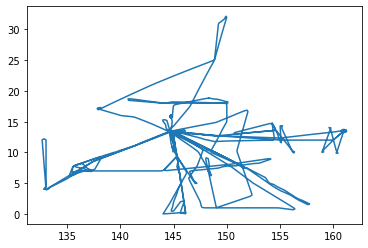

In [345]:
plt.plot(toga_trc.GGLON, toga_trc.GGLAT)

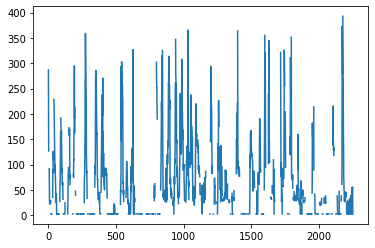

In [347]:
plt.plot(toga_trc.Acetaldehyde)